In [1]:
import pandas as pds
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    

In [33]:
# load csv files into dataframes
# the paramaters low_memory=False, dtype=str tell pandas not to guess the datatype
# and make everything a string
# note: many posts say low_memory=False doesn't do anything ... 
df_patients = pds.read_csv('patients.csv', low_memory=False, dtype=str, encoding='utf-8')
df_patients_teeth = pds.read_csv('patient_teeth.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_caries = pds.read_csv('tooth_caries.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_surface_caries = pds.read_csv('tooth_surface_caries.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_procedures = pds.read_csv('tooth_procedures_no_es.csv', low_memory=False, dtype=str, encoding='utf-8')
df_tooth_surface_procedures = pds.read_csv('tooth_surface_procedures_no_es.csv', low_memory=False, dtype=str, encoding='utf-8')

In [322]:
# drop duplicates from dataframes
df_patients.drop_duplicates(inplace=True)
df_patients_teeth.drop_duplicates(inplace=True)
df_tooth_caries.drop_duplicates(inplace=True)
df_tooth_surface_caries.drop_duplicates(inplace=True)
df_tooth_procedures.drop_duplicates(inplace=True)
df_tooth_surface_procedures.drop_duplicates(inplace=True)

In [207]:
# testing output
# df_patients.head() # good
# df_patients_teeth.head() # good
# df_tooth_caries.head() # good
# df_tooth_surface_caries.head() # good
# df_tooth_procedures.head() # good
# df_tooth_surface_procedures.head() # good

In [323]:
# len(df_patients_teeth)

In [325]:
# merge patients and teeth dataframes 
df_teeth = pds.merge(df_patients, df_patients_teeth, how='inner', on=['practice', 'patient_id']).drop_duplicates()
# df_teeth.head()

In [326]:
# len(df_teeth)

In [327]:
# create dataframe of teeth involved in procdures
df_teeth = df_teeth[df_teeth.tooth_id.isin(df_tooth_procedures.tooth_id)].drop_duplicates()
# len(df_teeth)

In [328]:
# df_teeth.head()

In [329]:
# merge procedures and surface data frames
# this results in surface information being included to with procedure
# information (when applicable)
df_procedures = pds.merge(df_tooth_procedures, df_tooth_surface_procedures, how='left', \
                                               on=['event_id', 'tooth_id', 'tooth_num']).drop_duplicates()
# fill NaN with '0'
df_procedures = df_procedures.fillna(0)
# df_procedures.head()

In [330]:
# len(df_teeth)

In [331]:
# merge teeth and procedures data frames
# this links patients, teeth, and procedures together
df_obs = pds.merge(df_teeth, df_procedures, \
                             how='inner', on=['tooth_id', 'tooth_num'])
df_obs.drop_duplicates(inplace=True)
# df_obs.head()

In [332]:
# print column names for easy reference
print(df_obs.columns)

Index(['practice', 'patient_id', 'gender', 'dob', 'first_visit', 'last_visit', 'tooth_id', 'tooth_num', 'first_PCR', 'first_RCT', 'extract_date', 'missing_date', 'exception', 'event_id', 'event_name', 'event_date', 'ada_code', 'm', 'o', 'd', 'b', 'l', 'f', 'i'], dtype='object')


In [333]:
# convert columns to datetime datatype (in case they aren't stored as datetimes)
df_obs.dob = pds.to_datetime(df_obs.dob)
df_obs.first_visit = pds.to_datetime(df_obs.first_visit, errors = 'coerce')
df_obs.last_visit = pds.to_datetime(df_obs.last_visit, errors = 'coerce')
df_obs.first_PCR = pds.to_datetime(df_obs.first_PCR, errors = 'coerce')
df_obs.first_RCT = pds.to_datetime(df_obs.first_RCT, errors = 'coerce')
df_obs.event_date = pds.to_datetime(df_obs.event_date, errors = 'coerce')
df_obs.extract_date = pds.to_datetime(df_obs.extract_date, errors = 'coerce')
df_obs.missing_date = pds.to_datetime(df_obs.missing_date, errors = 'coerce')

# df_obs.head()

In [334]:
# add patient ages to observations (using year 2017)
df_obs['patient_age'] = 2017 - pds.to_datetime(df_obs.dob).dt.year

# df_obs[['dob', 'patient_age']].head()

In [335]:
# some of the patient ages are less than zero due to bad DOB data
# let's drop the records
df_obs = pds.DataFrame(df_obs.query('patient_age > 0'))

# df_obs[['dob', 'patient_age']].head()
# df_obs.head()

In [336]:
# df_teeth.tooth_num.count()
# df_teeth.groupby('tooth_num').count()

# temp = df_teeth[~np.isnat(df_teeth.extract_date)]
# temp = df_teeth[~df_teeth.extract_date.isnull()]
# temp = temp.query("tooth_num == '7'")
# temp.groupby('tooth_num').count()
# temp.head()

In [337]:
# create dataframe of patient demographics
# note the use of drop_duplicates so that we have distict patients
df_demographics = df_obs[['practice', 'patient_id', 'gender', 'dob', 'patient_age']].drop_duplicates()

# df_demographics.head()

In [338]:
# print number of patients
# alternative method: df_demographics.count() -> 219037
len(df_demographics) # simplier

218560

In [339]:
# print out gender counts
# 122945 + 122945 = 122945
grouped = df_demographics.groupby('gender')['patient_id'].count()
print(grouped)

gender
female    122743
male       95817
Name: patient_id, dtype: int64


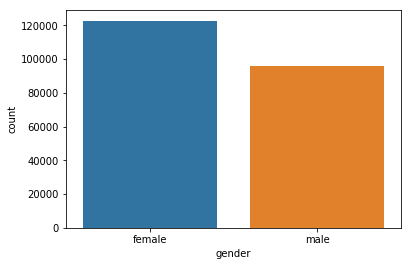

In [340]:
# plot gender counts
ax = sns.countplot(x="gender", data=df_demographics)

In [341]:
# create separate dataframes for genders
# there is probably a better way to do this ...
df_females = df_demographics.query("gender == 'female'")[['gender', 'patient_age']]
df_males = df_demographics.query("gender == 'male'")[['gender', 'patient_age']]

# testing output
# df_females.head()
# print(len(df_females))
# df_females.groupby('patient_age').count()

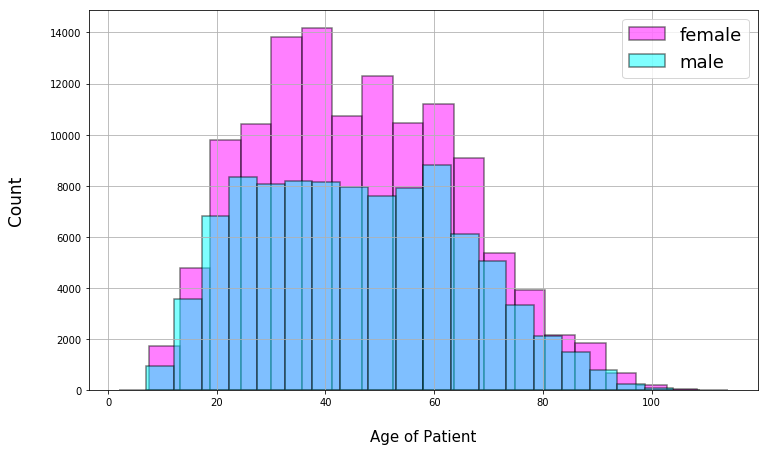

In [342]:
# plot age/gender distribution
ax = df_females["patient_age"]\
        .hist(bins=20, alpha=0.5, color='magenta', label='female', edgecolor='black', linewidth=1.5,figsize=(12,7))
ax = df_males["patient_age"]\
        .hist(bins=20, alpha=0.5, color='cyan', label='male', edgecolor='black', linewidth=1.5, figsize=(12,7))

ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Count\n", fontsize=17)

plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [343]:
# build dataframe of restorations on surfaces
df_fillings = df_obs[['tooth_id', 'tooth_num', 'ada_code', 'event_name', 'm','o', 'd', 'b', 'l', 'f', 'i']]
# df_fillings = df_fillings.query(""" \
#                     ada_code.str.startswith('D') \
#                     and event_name.str.contains('filling') \
#                     and (m==1 or o==1 or d==1 or b==1 or l==1 or f==1 or i==1)"""
#                     , engine="python") # engine="python" is needed for str functions to work
# df_fillings = df_fillings.query(""" m==1 or o==1 or d==1 or b==1 or l==1 or f==1 or i==1"""
#                                     , engine="python") # engine="python" is needed for str functions to work
df_fillings.m = pds.to_numeric(df_fillings.m)
df_fillings.o = pds.to_numeric(df_fillings.o)
df_fillings.d = pds.to_numeric(df_fillings.d)
df_fillings.b = pds.to_numeric(df_fillings.b)
df_fillings.l = pds.to_numeric(df_fillings.l)
df_fillings.f = pds.to_numeric(df_fillings.f)
df_fillings.i = pds.to_numeric(df_fillings.i)
# df_fillings.head()

/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [344]:
# add column with number of surfaces restored during procedure
df_fillings['num_restored_surfaces'] = df_fillings.m + df_fillings.o + df_fillings.d \
                                       + df_fillings.b + df_fillings.l + df_fillings.f + df_fillings.i

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [345]:
df_fillings.num_restored_surfaces = pds.to_numeric(df_fillings.num_restored_surfaces)
df_fillings = df_fillings[df_fillings.num_restored_surfaces > 0]
df_fillings.head()

/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,tooth_id,tooth_num,ada_code,event_name,m,o,d,b,l,f,i,num_restored_surfaces
7,A_1_1_3273_18,18,D2391,resin filling restoration procedure,0,1,0,0,0,0,0,1
8,A_1_1_3273_14,14,D2150,amalgam filling restoration procedure,1,0,0,0,1,0,0,2
9,A_1_1_3273_9,9,D2331,resin filling restoration procedure,1,0,0,0,0,0,1,2
10,A_1_1_3273_24,24,D2330,resin filling restoration procedure,0,0,0,0,0,0,1,1
11,A_1_1_3273_25,25,D2330,resin filling restoration procedure,0,0,0,0,0,0,1,1


In [346]:
# df_fillings.head()

In [347]:
# find number of procedures per tooth
# tooth_counts = pds.DataFrame(df_fillings.groupby('tooth_num')['tooth_num'].count())
tooth_counts = df_fillings.groupby('tooth_num')['tooth_num'].count()
# tooth_counts['num_int'] = tooth_counts.
tooth_counts.columns = ['count']
tooth_counts.index = pds.to_numeric(tooth_counts.index)
tooth_counts.sort_index(inplace=True) # sort data by tooth number 1 -> 32
# tooth_counts

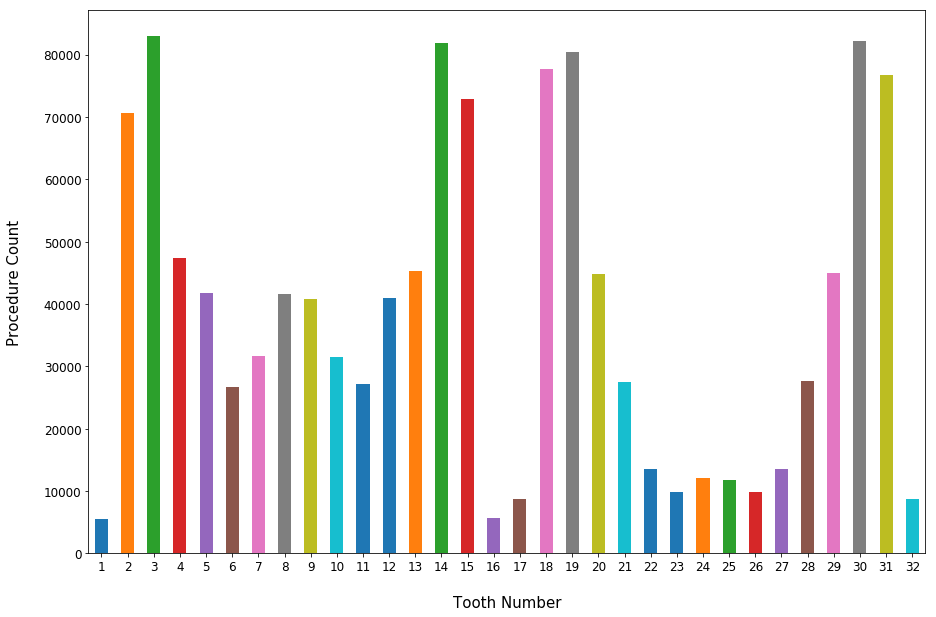

In [348]:
%matplotlib inline
# draw bar chart showing the number of procedures performed on each tooth (number)
ax = tooth_counts.plot.bar(figsize=(15,10)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Procedure Count\n", fontsize=15)
ax.tick_params(labelsize='large')

plt.show()

In [370]:
import numpy
nan = numpy.nan
# build dataframe of teeth that have been extracted or missing
# note the use of engine="python"
df_missing = df_obs[df_obs.extract_date.notnull() | df_obs.missing_date.notnull()]

# df_missing = df_obs[ ~np.isnat(df_obs.extract_date) | ~np.isnat(df_obs.missing_date)]

# temp = df_missing[['tooth_id', 'tooth_num', 'extract_date', 'missing_date']]
# temp.head()
# temp.groupby('tooth_num').count()

In [405]:
def missing_flag_by_row(row):
    if pds.notnull(row['extract_date']) or pds.notnull(row['missing_date']):
        return 1
    else:
        return 0

def pcr_flag_by_row(row):
    if pds.notnull(row['extract_date']) or pds.notnull(row['missing_date']):
        return 1
    else:
        return 0

def pcr_flag_by_columns(extract_date, missing_date):
    if pds.notnull(extract_date) or pds.notnull(missing_date):
        return 1
    else:
        return 0

def pcr_flag_by_df(df):
    if pds.notnull(df.extract_date) or pds.notnull(df.missing_date):
        df['PCR_flag'] = 1
    else:
        df['PCR_flag'] = 0

# temp = df_obs.iloc[:100000, :]
temp = df_obs
temp['missing_flag'] = temp.apply(missing_flag_by_row, axis=1)

df_missing = temp[temp.missing_flag == 1]
# temp[['extract_date', 'missing_date', 'missing_flag']][temp.missing_flag == 0].head()

In [408]:
df_missing[df_missing.missing_flag == 0].head() # should be none ...

,practice,patient_id,gender,dob,first_visit,last_visit,tooth_id,tooth_num,first_PCR,first_RCT,...,ada_code,m,o,d,b,l,f,i,patient_age,missing_flag


In [409]:
# find counts for each tooth type

# missing_counts = temp.groupby('tooth_num')['tooth_num'].value_counts()
missing_counts = df_missing.groupby('tooth_num').size()
missing_counts.index = pds.to_numeric(missing_counts.index)
missing_counts.sort_index(inplace=True)
missing_counts

tooth_num
1      229
2     2364
3     2907
4     1920
5     1570
6     1100
7     1172
8     1659
9     1557
10    1135
11    1076
12    1626
13    1825
14    2816
15    2338
16     197
17     290
18    2639
19    2777
20    1769
21    1015
22     670
23     423
24     603
25     563
26     461
27     683
28    1066
29    1733
30    2840
31    2475
32     276
dtype: int64

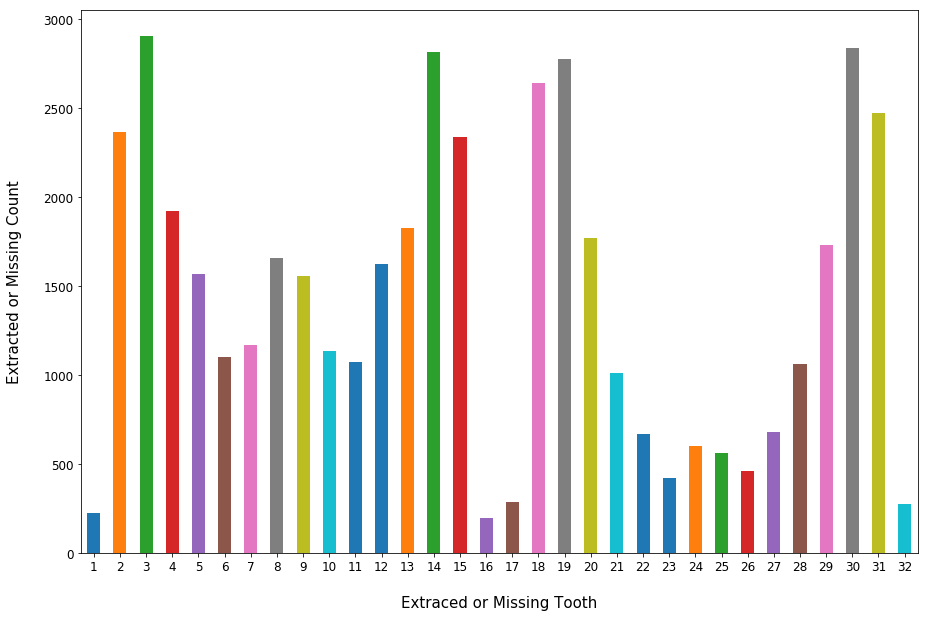

In [410]:
# draw bar chart showing the number of extracted or missing teeth for each tooth (number)
ax = missing_counts.plot.bar(figsize=(15,10)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nExtraced or Missing Tooth", fontsize=15)
ax.set_ylabel("Extracted or Missing Count\n", fontsize=15)
ax.tick_params(labelsize='large')

plt.show()

# DOES THIS PLOT MAKE SENSE? IT SEEMS WRONG. IT SEEMS LIKE THERE SHOULD BE MORE WISDOM TEETH MISSING.

In [352]:
# create dataframe of only suface info
df_surfaces = df_fillings[['m', 'o', 'd', 'b', 'l', 'f', 'i', 'num_restored_surfaces']]

# df_surfaces.head()

In [353]:
# calc number of surfaces restored for each surface
# note we are ignoring the number of restored surfaces (for now)
surface_counts = df_surfaces[['m', 'o', 'd', 'b', 'l', 'f', 'i']].apply(sum)

# surface_counts

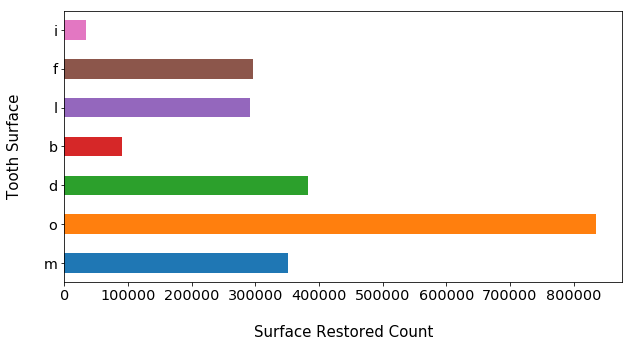

In [411]:
# create bar chart (flipped on its side) to show number of restorations per service
ax = surface_counts.plot.barh(figsize=(10,5))

# configure labels
ax.set_xlabel("\nSurface Restored Count", fontsize=15)
ax.set_ylabel("Tooth Surface\n", fontsize=15)
ax.tick_params(labelsize='x-large')

plt.show()

In [355]:
# calc number of surfaces restored on a tooth for each procedure (i.e., number of surfaces filled during procedure)
temp = pds.DataFrame(df_fillings[['tooth_num', 'num_restored_surfaces']]\
                        .groupby(['num_restored_surfaces', 'tooth_num']).size())

# temp.head()

In [356]:
# note the use of fill_values for NaN
restored_surface_counts = temp.unstack('num_restored_surfaces', fill_value=0)
restored_surface_counts.columns = ['1', '2', '3', '4', '5', '6']

# restored_surface_counts

In [357]:
# do some checks
# df_fillings.query('tooth_num == 32 and num_restored_surfaces == 5')['num_restored_surfaces'].count() # matches
# df_fillings.query('tooth_num == 30 and num_restored_surfaces == 5')['num_restored_surfaces'].count() # matches
# df_fillings.query('tooth_num == 20 and num_restored_surfaces == 2')['num_restored_surfaces'].count() # matches

In [358]:
# make simple plot of counts
# first do a check, and note that there are only 3 restorations of 6 surfaces (which seems not possible)
# the heatmap also reflects this ...
counts_per_surface = pds.DataFrame(restored_surface_counts.apply(sum))

# set index and column name
counts_per_surface.index.name = 'num_surfaces_restored'
counts_per_surface.columns = ['count']

# counts_per_surface

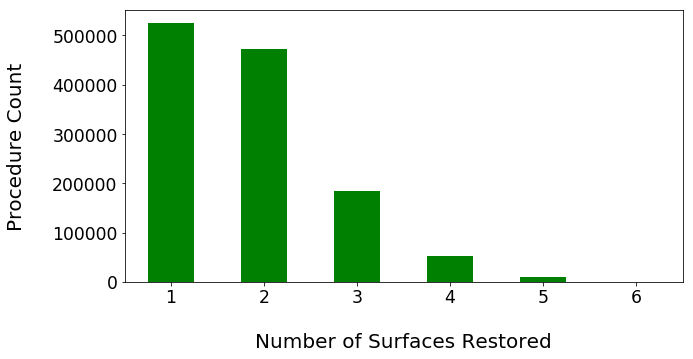

In [412]:
ax = counts_per_surface.plot.bar(figsize=(10,5), color='green', legend=False)

# configure X and Y labels
ax.set_xlabel("\nNumber of Surfaces Restored", fontsize=20)
ax.set_ylabel("Procedure Count\n", fontsize=20)
ax.tick_params(labelsize='xx-large')

# rotate the ticks on the x axis
plt.xticks(rotation=0)

plt.show()

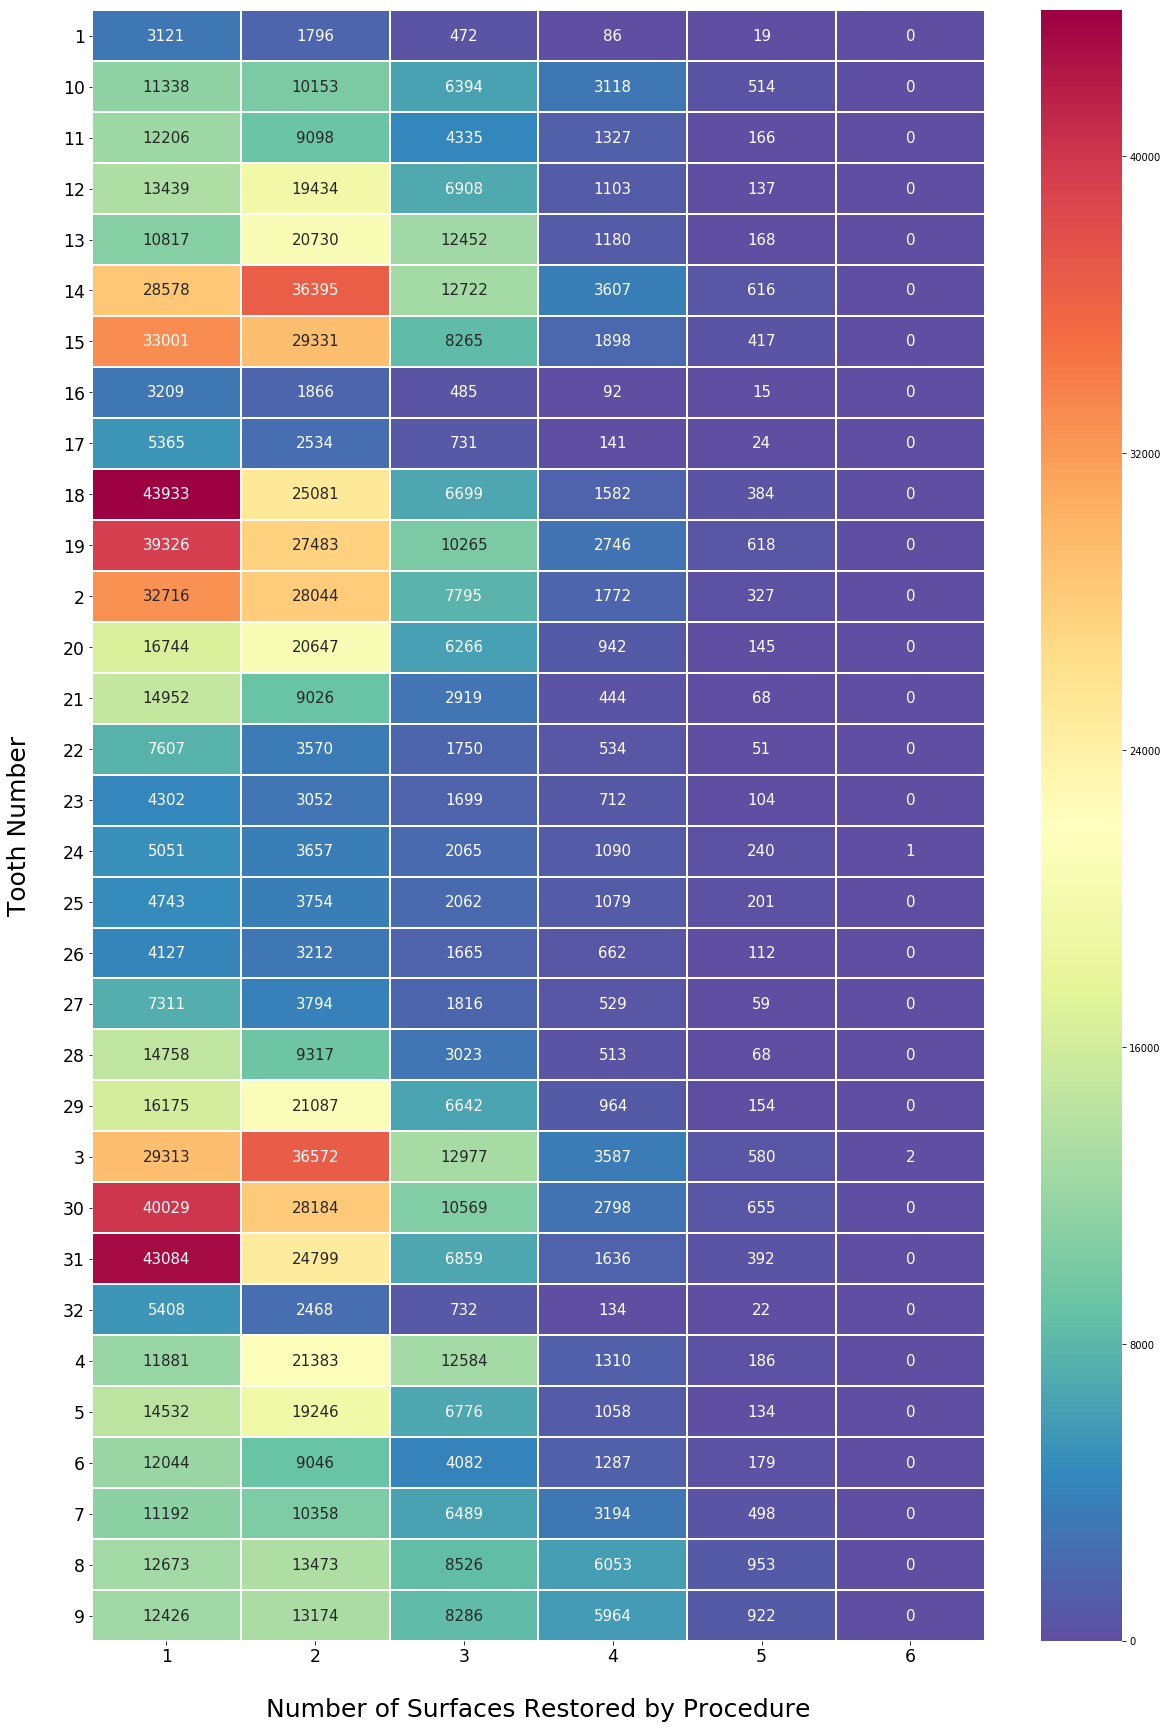

In [413]:
plt.figure(figsize = (20,30)) # this sets width and height of the figure

# fmt='d' means annotations are digits, annot_kws={"size":15} sets the size of the annotation font
ax = sns.heatmap(restored_surface_counts, cmap='Spectral_r', linewidths=1.0, annot=True, fmt='d', annot_kws={"size":15})

# rotate the ticks on the y axis
plt.yticks(rotation=0)

# configure X and Y labels
ax.set_ylabel("Tooth Number\n", fontsize=25)
ax.set_xlabel("\nNumber of Surfaces Restored by Procedure", fontsize=25)
ax.tick_params(labelsize='xx-large')

plt.show()

In [361]:
# create a data structures to show a heatmap of teeth and surfaces
# build dataframe of tooth and surface info
df_tooth_surfaces = df_fillings[['tooth_num', 'm', 'o', 'd', 'b', 'l', 'f', 'i']]

# df_tooth_surfaces.head()

In [368]:
# for each tooth group, sum the surfaces restored
grouped_df = pds.DataFrame(df_tooth_surfaces.groupby('tooth_num').sum())
grouped_df.columns = ['m', 'o', 'd', 'b', 'l', 'f', 'i']
grouped_df.index = pds.to_numeric(grouped_df.index)
grouped_df.sort_index(inplace=True)
grouped_df.head()

,m,o,d,b,l,f,i
tooth_num,,,,,,,
1,1362,4605,589,428,927,656,1
2,17929,60891,10355,3939,21538,6250,10
3,27204,70598,17139,3057,35187,5449,14
4,20072,40405,28180,2330,3018,4550,14
5,9592,31047,23819,3668,2412,7702,14


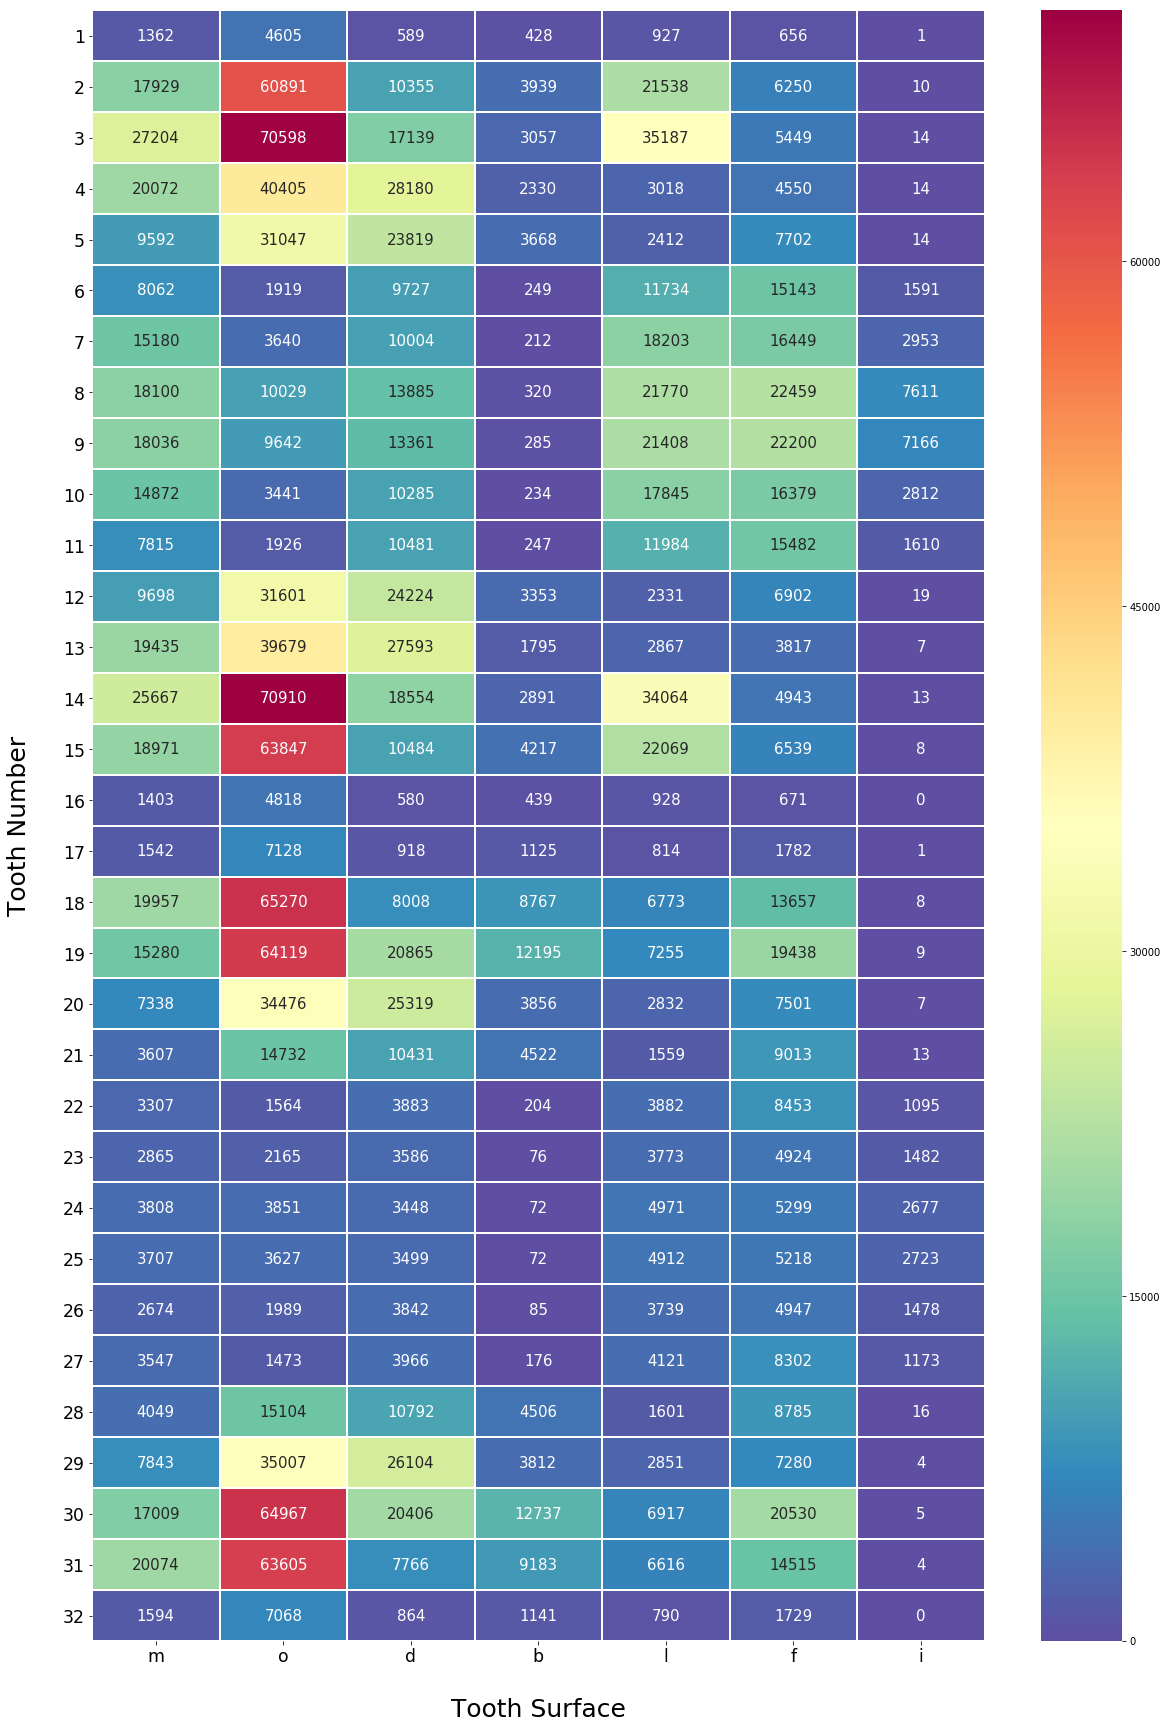

In [414]:
# make a heat map that shows the number of surfaces restored per tooth
# the surface is on the X axis, the tooth is on the Y axis

plt.figure(figsize = (20,30)) # this sets width and height of the figure

# fmt='d' means annotations are digits
ax = sns.heatmap(grouped_df, cmap='Spectral_r', linewidths=1.0, annot=True, fmt='d', annot_kws={"size":15})

# rotate the ticks on the y axis
plt.yticks(rotation=0)

# configure X and Y labels
ax.set_xlabel("\nTooth Surface", fontsize=25)
ax.set_ylabel("Tooth Number\n", fontsize=25)
ax.tick_params(labelsize='xx-large')

plt.show()
